In [99]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from datetime import datetime
from utils.mvo_strategy import MVOPortfolio

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
sector_tickers = [
    "XLF",  # Financials
    "XLK",  # Technology
    "XLV",  # Health Care
    "XLY",  # Consumer Discretionary
    "XLP",  # Consumer Staples
    "XLE",  # Energy
    "XLI",  # Industrials
    "XLU",  # Utilities
    "XLB",  # Materials
    "XLRE",  # Real Estate
    "XLC",  # Communication Services
]

# import data from csv
df_ret = pd.read_parquet("../data/returns.parquet")
df_prices = pd.read_parquet("../data/prices.parquet")
df_vol = pd.read_parquet("../data/vola.parquet")

df_spy = pd.read_parquet("../data/prices_sp500.parquet")

In [101]:
# Test different lookback periods
lookback_periods = [10, 30, 60, 90, 120, 150, 252, 252 * 2, 252 * 3, 252 * 3.5]
# make sure all are integers
lookback_periods = [int(period) for period in lookback_periods]

# full date range from paper
# START_DATE = "2006-01-01"
# END_DATE = "2021-12-31"

yr = 2011
START_DATE = f"{yr}-01-01"
END_DATE = f"{yr}-12-31"

In [102]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
# also add start and end date to the name
results_dir = f"../results/{timestamp}_mvo_backtest_[{START_DATE},{END_DATE}]/"
os.makedirs(results_dir, exist_ok=True)

In [103]:
all_history = []
all_metrics = []

for lookback in lookback_periods:
    print(f"Running MVO with lookback period: {lookback}")
    optimizer = MVOPortfolio(tickers=sector_tickers, lookback=lookback)
    portfolio = optimizer.backtest(
        df_ret, df_prices, start_date=START_DATE, end_date=END_DATE
    )

    portfolio_df = pd.DataFrame(portfolio.get_history())
    portfolio_df["lookback"] = lookback

    portfolio_metrics = portfolio.calc_metrics()
    portfolio_metrics["lookback"] = lookback

    all_history.append(portfolio_df)
    all_metrics.append(portfolio_metrics)

Running MVO with lookback period: 10


Running backtest: 100%|██████████| 260/260 [00:01<00:00, 141.49it/s]


Running MVO with lookback period: 30


Running backtest: 100%|██████████| 260/260 [00:02<00:00, 112.30it/s]


Running MVO with lookback period: 60


Running backtest: 100%|██████████| 260/260 [00:02<00:00, 103.10it/s]


Running MVO with lookback period: 90


Running backtest: 100%|██████████| 260/260 [00:02<00:00, 98.48it/s] 


Running MVO with lookback period: 120


Running backtest: 100%|██████████| 260/260 [00:02<00:00, 88.45it/s]


Running MVO with lookback period: 150


Running backtest: 100%|██████████| 260/260 [00:03<00:00, 81.37it/s]


Running MVO with lookback period: 252


Running backtest: 100%|██████████| 260/260 [00:03<00:00, 70.12it/s]


Running MVO with lookback period: 504


Running backtest: 100%|██████████| 260/260 [00:03<00:00, 67.00it/s]


Running MVO with lookback period: 756


Running backtest: 100%|██████████| 260/260 [00:04<00:00, 57.59it/s]


Running MVO with lookback period: 882


Running backtest: 100%|██████████| 260/260 [00:04<00:00, 60.03it/s]


In [104]:
# Combine all results
history_df = pd.concat(all_history, axis=0)
metrics_df = pd.DataFrame(all_metrics)

history_df.to_parquet(f"{results_dir}/mvo_history.parquet")
metrics_df.to_csv(f"{results_dir}/mvo_metrics.csv")

In [105]:
# # Load df from previous run
# results_dir = "../results/20250602_010152_mvo_backtest"
# history_df = pd.read_parquet(f"{results_dir}/mvo_history.parquet")
# metrics_df = pd.read_csv(f"{results_dir}/mvo_metrics.csv")

In [106]:
# compare with portfolio value development if i just buy and hold SPY
initial_balance = 100_000
shares_spy = initial_balance / df_spy["^GSPC"].loc[df_spy.index > START_DATE].iat[0]

# print(df_spy["^GSPC"].loc[END_DATE] * shares_spy)
# get closest date in df_spy thats before END_DATE
spy_lastdate = df_spy["^GSPC"].loc[df_spy.index < END_DATE].index.max()
spy_lastval = (df_spy.loc[spy_lastdate] * shares_spy).values[0]
print(f"SnP500 final value: {spy_lastval:.2f}")

# compare if MVO with lookback outperforms SnP500
# simple comparison with True False in new column
df = history_df.groupby("lookback")[['portfolio_value']].last().sort_values(by="portfolio_value", ascending=False)
df["outperforms_spy"] = df["portfolio_value"] > spy_lastval
df

SnP500 final value: 98878.03


,portfolio_value,outperforms_spy
lookback,,
120,118108.519068,True
90,114846.969397,True
882,114259.798737,True
150,114079.926495,True
60,110602.272243,True
504,110585.983162,True
756,106720.422081,True
10,105936.757735,True
30,101100.370343,True


In [107]:
# reset sns style
sns.reset_defaults()

# PLOT Portfolio Value Development
plt.figure(figsize=(15, 5))
palette = sns.color_palette(
    "coolwarm", as_cmap=False, n_colors=history_df["lookback"].nunique()
)
sns.lineplot(
    data=history_df, x="date", y="portfolio_value", hue="lookback", palette=palette, lw=1
)

plt.plot(df_spy["^GSPC"].loc[START_DATE:END_DATE] * shares_spy, c="k", label="SnP500", lw=1)

plt.title("Portfolio Value Development by Lookback Period")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
# save plot
plt.savefig(f"{results_dir}/portfolio_value_development.pdf", dpi=300)

In [108]:
# Filter relevant lookback
lookback = 60
focus_df = history_df[history_df['lookback'] == lookback]

# === Monthly returns ===
month_df = focus_df[['portfolio_value']].resample('ME').last()
month_df = pd.concat([pd.DataFrame({'portfolio_value': [initial_balance]}, index=[month_df.index.min() - pd.DateOffset(months=1)]), month_df])
month_df['monthly_ret'] = month_df['portfolio_value'].pct_change() * 100
month_df = month_df.iloc[1:]
month_df['year'] = month_df.index.year
month_df['month'] = month_df.index.month
monthly_pivot = month_df.pivot(index='year', columns='month', values='monthly_ret')
monthly_rets = month_df['monthly_ret'].values

# === Annual returns ===
annual_df = focus_df[['portfolio_value']].resample('YE').last()
annual_df = pd.concat([pd.DataFrame({'portfolio_value': [initial_balance]}, index=[annual_df.index.min() - pd.DateOffset(years=1)]), annual_df])
annual_df['annual_ret'] = annual_df['portfolio_value'].pct_change() * 100
annual_df = annual_df.iloc[1:]
annual_df['year'] = annual_df.index.year
annual_mean = annual_df['annual_ret'].mean()

# === PLOT with square plots and updated formatting ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.set_theme()

# 1. Monthly heatmap
sns.heatmap(
    monthly_pivot,
    cmap="RdYlGn",
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[0],
    cbar=False,
    linewidths=0.2,
    linecolor='white'
)
axes[0].set_title("Monthly returns (%)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Year")
axes[0].set_aspect('equal')

# 2. Annual returns bar chart (scaled to %)
axes[1].barh(annual_df['year'], annual_df['annual_ret'], color="cornflowerblue")
axes[1].axvline(x=annual_mean, color="dodgerblue", linestyle="--", lw=3, label="Mean")
axes[1].set_title("Annual returns")
axes[1].set_yticks(annual_df['year'])

# 3. Monthly return distribution
axes[2].hist(monthly_rets, bins=20, color="#ff5812", edgecolor="white")
axes[2].axvline(x=monthly_rets.mean(), color="gold", linestyle="--", lw=3, label="Mean")
axes[2].set_title("Distribution of monthly returns")
axes[2].set_ylabel("Number of months")

for idx in [1,2]:
    axes[idx].axvline(x=0, color="black", lw=2)
    axes[idx].set_xlabel("Returns (%)")
    axes[idx].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    axes[idx].legend()

plt.suptitle(f"Returns for lookback = {lookback}")

plt.tight_layout()
plt.savefig(f"{results_dir}/paper_figure4_returns_{lookback}.pdf", dpi=300)

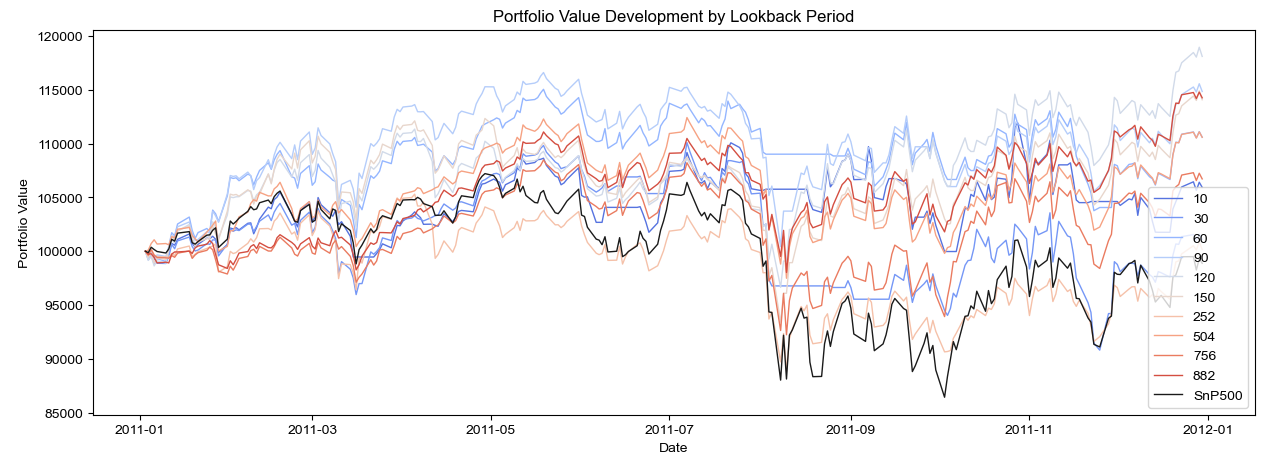

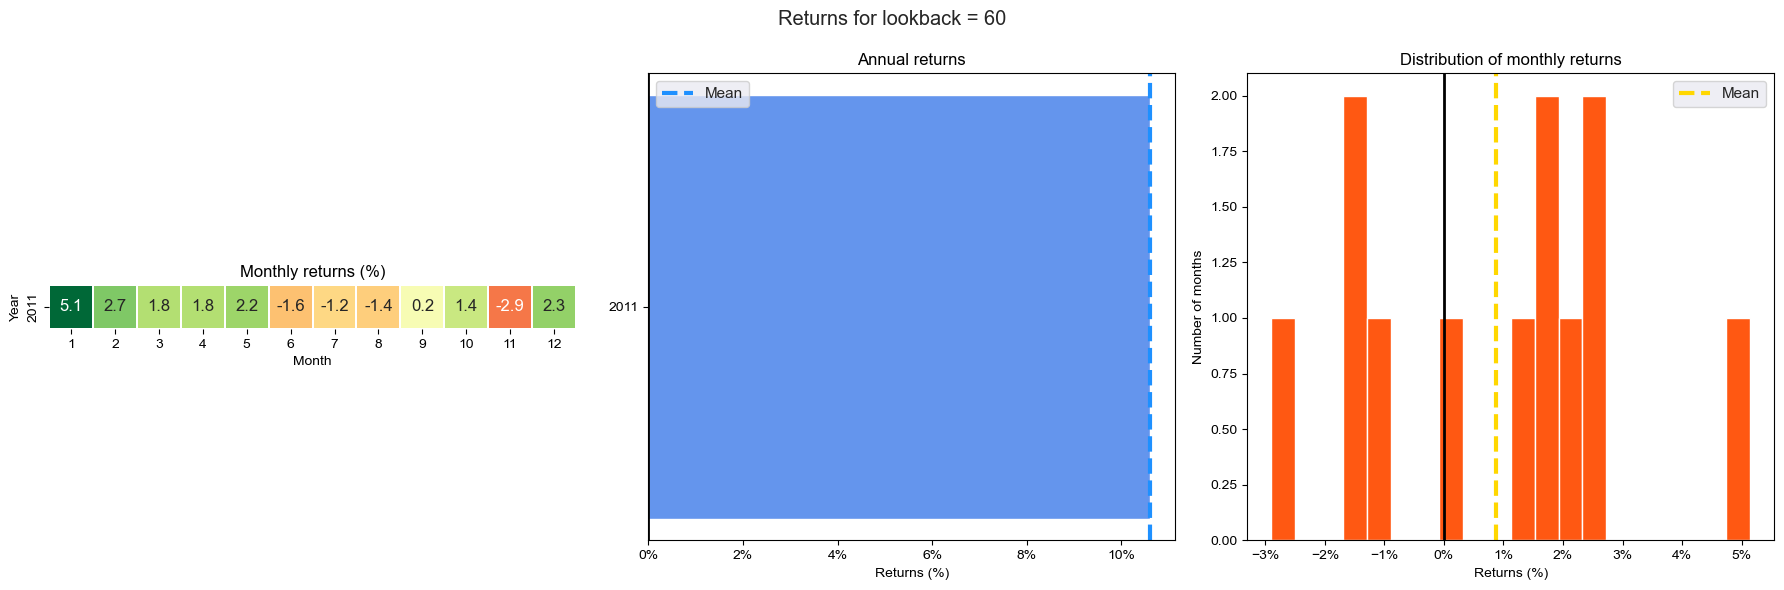

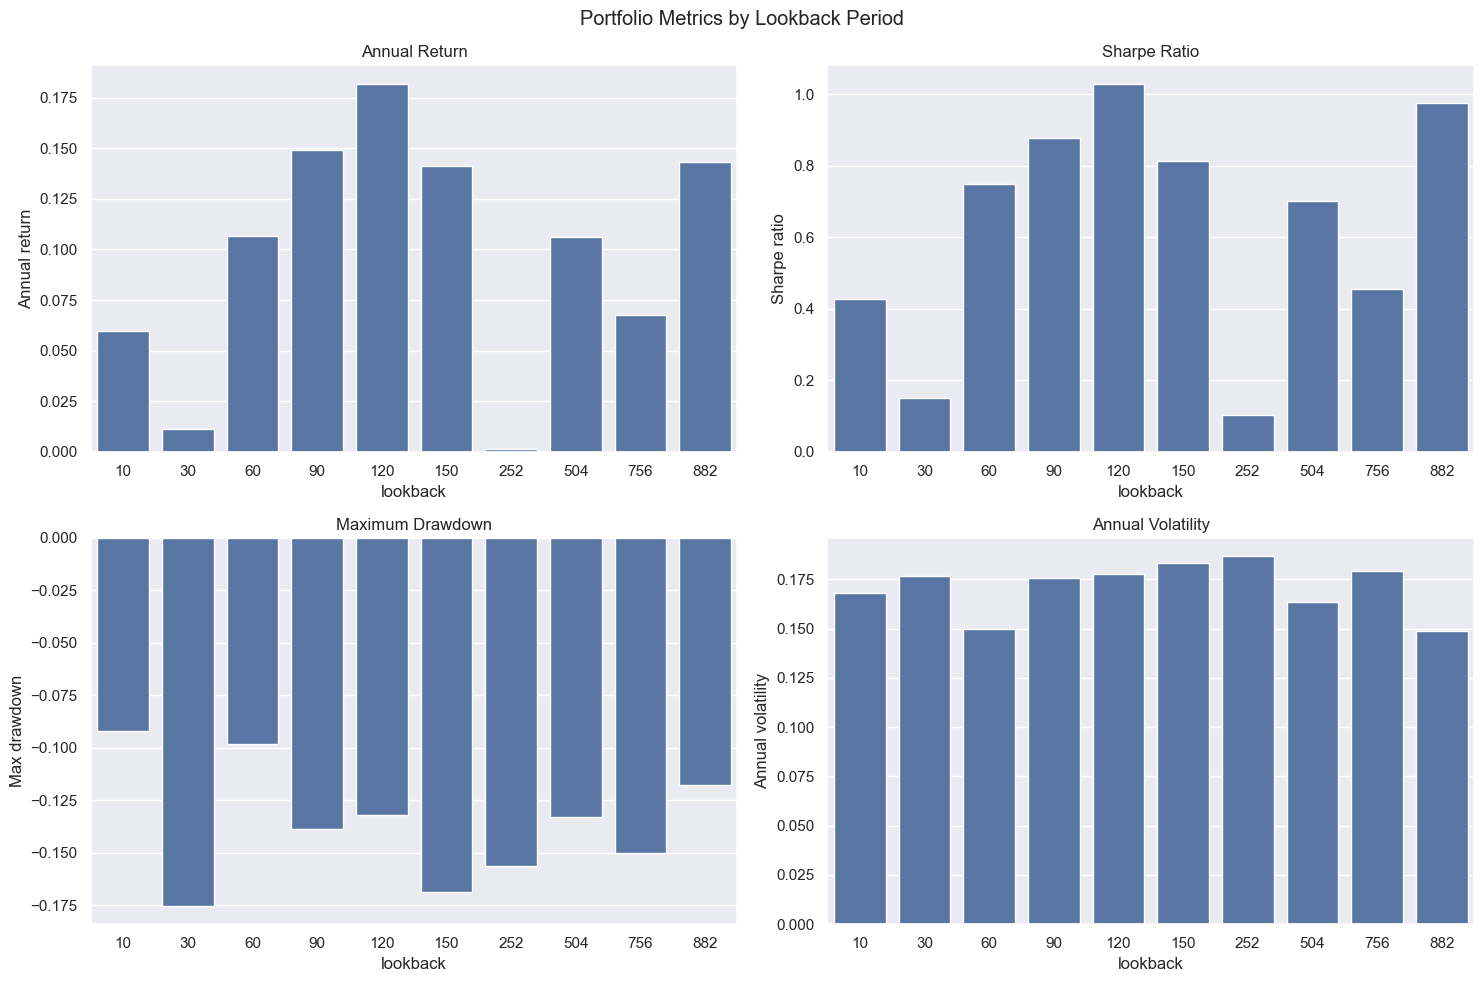


Detailed Metrics by Lookback Period:


lookback,10,30,60,90,120,150,252,504,756,882
Annual return,0.059611,0.011048,0.106467,0.149103,0.181869,0.141398,0.001517,0.106303,0.067481,0.143205
Cumulative returns,0.059368,0.011004,0.106023,0.148470,0.181085,0.140799,0.001511,0.105860,0.067204,0.142598
Annual volatility,0.168227,0.176912,0.149788,0.175813,0.177679,0.183175,0.186718,0.163428,0.179110,0.148726
Sharpe ratio,0.428472,0.150727,0.750321,0.878786,1.029633,0.813979,0.101938,0.700382,0.454569,0.974746
Calmar ratio,0.649271,0.063046,1.085599,1.074933,1.376750,0.838711,0.009703,0.800001,0.450373,1.218063
Stability,0.855998,0.849681,0.869726,0.850475,0.849128,0.845184,0.842660,0.859529,0.848098,0.870529
Max drawdown,-0.091812,-0.175234,-0.098072,-0.138709,-0.132100,-0.168590,-0.156313,-0.132879,-0.149833,-0.117568
Omega ratio,1.085433,1.029189,1.136411,1.160959,1.183250,1.143953,1.017528,1.124375,1.083589,1.178095
Sortino ratio,0.529208,0.189723,1.210081,1.285525,1.603390,1.203289,0.132703,0.894611,0.578772,1.282268
Skew,-0.215479,-0.207321,0.261613,-0.275687,-0.125946,-0.314483,-0.603417,-0.729154,-0.558586,-0.632400


In [109]:
# Plot key metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Portfolio Metrics by Lookback Period")

# Annual Return
sns.barplot(data=metrics_df, x="lookback", y="Annual return", ax=axes[0, 0])
axes[0, 0].set_title("Annual Return")

# Sharpe Ratio
sns.barplot(data=metrics_df, x="lookback", y="Sharpe ratio", ax=axes[0, 1])
axes[0, 1].set_title("Sharpe Ratio")

# Max Drawdown
sns.barplot(data=metrics_df, x="lookback", y="Max drawdown", ax=axes[1, 0])
axes[1, 0].set_title("Maximum Drawdown")

# Volatility
sns.barplot(data=metrics_df, x="lookback", y="Annual volatility", ax=axes[1, 1])
axes[1, 1].set_title("Annual Volatility")

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Metrics by Lookback Period:")
df = metrics_df.set_index("lookback")
df.T